In [ ]:
import json, re, string, datetime, tweepy, requests
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
import nltk, gensim, tqdm
from bs4 import BeautifulSoup
from tabulate import tabulate
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.lancaster import LancasterStemmer
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from wordcloud import WordCloud
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from requests_oauthlib import OAuth1
from urllib.request import urlopen

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### **Data Understanding**

In [ ]:
df_test = pd.read_csv('/content/test_question.csv')
df_test

,Unnamed: 0,text,category,product_name,product_id
0,0,Warnanya tdk sesuai pesanan. Tdk ada chat/pemb...,elektronik,USB HUB 3.0 7 port by DIGIGEAR HIGH SPEED 1.2 ...,170197447
1,1,Thanks gan barang bagus.smoga awet,handphone,Holder anti hujan &amp; copet untuk smartphone...,37564148
2,2,barang sesuai deskripsi.. laptop dapat di-charge,elektronik,Adaptor Charger Laptop Toshiba Satellite C800 ...,254339251
3,3,Goood product.......... ............,handphone,Silikon Case Blackberry Bold 9000 Hitam Gratis...,4837401
4,4,Bagus pengiriman cepat.,handphone,Audio Splitter Jack 3.5mm to dual female U Sha...,270447288
5,5,Terima kasih pesanannya sdh sampai,fashion,Celana jeans anak pendek,294837423
6,6,"barangnya cacat, apa tidak diperiksa dulu?",handphone,Tempelan / Perekat Gurita Hp Buat / untuk Goje...,56486193
7,7,Barang sesuai pesanan,elektronik,Baterai Acer Aspire One 722 D255 D257 D260 D27...,189413883
8,8,"Udah order ternyata stok ga tersedia, harusny...",fashion,Sepatu Bata Dairy Black - 6516353,194223236
9,9,Pengiriman barang lambat,elektronik,USB HUB 4 port USB 3.0 / USB HUB 3.0 &#40;4por...,182937734


In [ ]:
df_train = pd.read_csv('/content/traning_review_product.csv')
df_train

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,text,rating,category,product_name,product_id,sold,shop_id,product_url
0,0,0,1,Barang sesuai pesanan dan cepat sampai,5,pertukangan,Staples Dekorasi Staples Kayu + Refill 8mm - S...,418660637,1,1740837,https://www.tokopedia.com/shakaonline87/staple...
1,1,1,2,Barang bagus harga murah,5,pertukangan,STAPLE GUN ATS 3 WAY TACKER - STAPLES JOK TEMB...,416032545,11,1477109,https://www.tokopedia.com/juraganperkakas/stap...
2,2,2,3,Paket rapi...mantap....cepat....sampe ke tujuan,5,pertukangan,STAPLE GUN ATS 3 WAY TACKER - STAPLES JOK TEMB...,416032545,11,1477109,https://www.tokopedia.com/juraganperkakas/stap...
3,3,3,4,ya saya puas dgn barangnya,5,pertukangan,ALAT STAPLES TEMBAK &#40;AIR NAILER GUN&#41; O...,102279869,5,771395,https://www.tokopedia.com/kamarmesin/alat-stap...
4,4,4,5,Responya luar biasa b mantap,5,pertukangan,Isi Refill Staples Jok Kulit Motor / Staple Gu...,190679689,787,969999,https://www.tokopedia.com/mitrapersada/isi-ref...
...,...,...,...,...,...,...,...,...,...,...,...
40592,40602,40602,40889,gak bisa ditutup.. ukuran gak pas..,1,olahraga,MINERAL WATER POT WATER PURIFIER 28 liter BIO ...,144442054,2,648559,https://www.tokopedia.com/pusatdermawand/miner...
40593,40603,40603,40890,Penjual krg peduli dan brg jelek. Brg yg dikir...,1,olahraga,PANCI PRESTO IDEALIFE 7 LITER - IL 707 &#40; I...,313781913,1,648559,https://www.tokopedia.com/pusatdermawand/panci...
40594,40604,40604,40891,"pelayanan kurang sigap, berhari2 dr nanya baik...",1,olahraga,EXCIDER BIKE 2 - sepeda fitnes magnetic lipat ...,71873370,1,648559,https://www.tokopedia.com/pusatdermawand/excid...
40595,40605,40605,40892,"barang yg dikirim tsk sesuai wrn, kl memang dr...",1,olahraga,TOTAL FITNES ALAT FITNESS SIT UP BENCH TOTAL &...,201690705,2,648559,https://www.tokopedia.com/pusatdermawand/total...


In [ ]:
def check_values(df_test):
    data = []
    for col in df_test.columns:
        data.append([col, \
                  df_test[col].dtype, \
                  df_test[col].isna().sum(), \
                  round(100*(df_test[col].isna().sum()/len(df_test)), 2), \
                  df_test[col].nunique(), \
                  df_test[col].unique()
                  ])

    return pd.DataFrame(columns=['kolom', 'dataType', 'null', 'nullPercentage', 'unique', 'values'], data=data)

In [ ]:
check_values(df_test)

,kolom,dataType,null,nullPercentage,unique,values
0,Unnamed: 0,int64,0,0.0,10,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]"
1,text,object,0,0.0,10,[Warnanya tdk sesuai pesanan. Tdk ada chat/pem...
2,category,object,0,0.0,3,"[elektronik, handphone, fashion]"
3,product_name,object,0,0.0,10,[USB HUB 3.0 7 port by DIGIGEAR HIGH SPEED 1.2...
4,product_id,int64,0,0.0,10,"[170197447, 37564148, 254339251, 4837401, 2704..."


In [ ]:
df_test.shape

(10, 5)

In [ ]:
def check_values(df_train):
    data = []
    for col in df_train.columns:
        data.append([col, \
                  df_train[col].dtype, \
                  df_train[col].isna().sum(), \
                  round(100*(df_train[col].isna().sum()/len(df_train)), 2), \
                  df_train[col].nunique(), \
                  df_train[col].unique()
                  ])

    return pd.DataFrame(columns=['kolom', 'dataType', 'null', 'nullPercentage', 'unique', 'values'], data=data)

In [ ]:
check_values(df_train)

,kolom,dataType,null,nullPercentage,unique,values
0,Unnamed: 0.2,int64,0,0.00,40597,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
1,Unnamed: 0.1,int64,0,0.00,40597,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
2,Unnamed: 0,int64,0,0.00,40597,"[1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 1..."
3,text,object,0,0.00,37292,"[Barang sesuai pesanan dan cepat sampai, Baran..."
4,rating,int64,0,0.00,5,"[5, 3, 4, 2, 1]"
5,category,object,0,0.00,5,"[pertukangan, fashion, elektronik, handphone, ..."
6,product_name,object,0,0.00,3646,[Staples Dekorasi Staples Kayu + Refill 8mm - ...
7,product_id,int64,0,0.00,3663,"[418660637, 416032545, 102279869, 190679689, 3..."
8,sold,object,14,0.03,305,"[1, 11, 5, 787, 82, 48, 9, 40, 545, 45, 171, 1..."
9,shop_id,int64,0,0.00,158,"[1740837, 1477109, 771395, 969999, 231740, 154..."


In [ ]:
df_train.shape

(40597, 11)

## **Pre-processing**

**Handling Missing Value**

In [ ]:
# menghapus baris yang missing value
df_train.dropna(inplace=True)
# menghapus bkolom yang dianggap tidak perlu
df_train.drop(["Unnamed: 0.2", "Unnamed: 0.1",'Unnamed: 0','product_id','shop_id'], axis=1, inplace=True)

In [ ]:
check_values(df_train)

,kolom,dataType,null,nullPercentage,unique,values
0,text,object,0,0.0,37278,"[Barang sesuai pesanan dan cepat sampai, Baran..."
1,rating,int64,0,0.0,5,"[5, 3, 4, 2, 1]"
2,category,object,0,0.0,5,"[pertukangan, fashion, elektronik, handphone, ..."
3,product_name,object,0,0.0,3645,[Staples Dekorasi Staples Kayu + Refill 8mm - ...
4,sold,object,0,0.0,305,"[1, 11, 5, 787, 82, 48, 9, 40, 545, 45, 171, 1..."
5,product_url,object,0,0.0,3662,[https://www.tokopedia.com/shakaonline87/stapl...


In [ ]:
df_train.shape

(40583, 6)

**EDA**

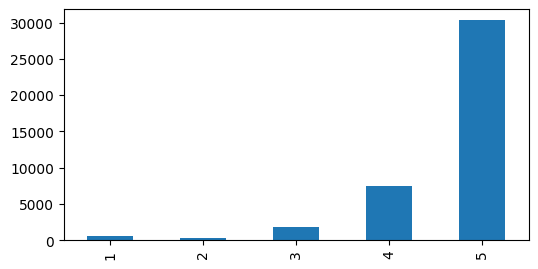

In [ ]:
rating = df_train['rating'].value_counts().sort_index().plot(kind='bar', figsize=(6,3))

**Rename**

In [ ]:
df_train.replace({"rating":{4:"Positive",5:"Positive",1:"Negative",2:"Negative",3:"Neutral"}}, inplace=True)
df_train

,text,rating,category,product_name,sold,product_url
0,Barang sesuai pesanan dan cepat sampai,Positive,pertukangan,Staples Dekorasi Staples Kayu + Refill 8mm - S...,1,https://www.tokopedia.com/shakaonline87/staple...
1,Barang bagus harga murah,Positive,pertukangan,STAPLE GUN ATS 3 WAY TACKER - STAPLES JOK TEMB...,11,https://www.tokopedia.com/juraganperkakas/stap...
2,Paket rapi...mantap....cepat....sampe ke tujuan,Positive,pertukangan,STAPLE GUN ATS 3 WAY TACKER - STAPLES JOK TEMB...,11,https://www.tokopedia.com/juraganperkakas/stap...
3,ya saya puas dgn barangnya,Positive,pertukangan,ALAT STAPLES TEMBAK &#40;AIR NAILER GUN&#41; O...,5,https://www.tokopedia.com/kamarmesin/alat-stap...
4,Responya luar biasa b mantap,Positive,pertukangan,Isi Refill Staples Jok Kulit Motor / Staple Gu...,787,https://www.tokopedia.com/mitrapersada/isi-ref...
...,...,...,...,...,...,...
40592,gak bisa ditutup.. ukuran gak pas..,Negative,olahraga,MINERAL WATER POT WATER PURIFIER 28 liter BIO ...,2,https://www.tokopedia.com/pusatdermawand/miner...
40593,Penjual krg peduli dan brg jelek. Brg yg dikir...,Negative,olahraga,PANCI PRESTO IDEALIFE 7 LITER - IL 707 &#40; I...,1,https://www.tokopedia.com/pusatdermawand/panci...
40594,"pelayanan kurang sigap, berhari2 dr nanya baik...",Negative,olahraga,EXCIDER BIKE 2 - sepeda fitnes magnetic lipat ...,1,https://www.tokopedia.com/pusatdermawand/excid...
40595,"barang yg dikirim tsk sesuai wrn, kl memang dr...",Negative,olahraga,TOTAL FITNES ALAT FITNESS SIT UP BENCH TOTAL &...,2,https://www.tokopedia.com/pusatdermawand/total...


In [ ]:
df_train

,text,rating,category,product_name,sold,product_url
0,Barang sesuai pesanan dan cepat sampai,Positive,pertukangan,Staples Dekorasi Staples Kayu + Refill 8mm - S...,1,https://www.tokopedia.com/shakaonline87/staple...
1,Barang bagus harga murah,Positive,pertukangan,STAPLE GUN ATS 3 WAY TACKER - STAPLES JOK TEMB...,11,https://www.tokopedia.com/juraganperkakas/stap...
2,Paket rapi...mantap....cepat....sampe ke tujuan,Positive,pertukangan,STAPLE GUN ATS 3 WAY TACKER - STAPLES JOK TEMB...,11,https://www.tokopedia.com/juraganperkakas/stap...
3,ya saya puas dgn barangnya,Positive,pertukangan,ALAT STAPLES TEMBAK &#40;AIR NAILER GUN&#41; O...,5,https://www.tokopedia.com/kamarmesin/alat-stap...
4,Responya luar biasa b mantap,Positive,pertukangan,Isi Refill Staples Jok Kulit Motor / Staple Gu...,787,https://www.tokopedia.com/mitrapersada/isi-ref...
...,...,...,...,...,...,...
40592,gak bisa ditutup.. ukuran gak pas..,Negative,olahraga,MINERAL WATER POT WATER PURIFIER 28 liter BIO ...,2,https://www.tokopedia.com/pusatdermawand/miner...
40593,Penjual krg peduli dan brg jelek. Brg yg dikir...,Negative,olahraga,PANCI PRESTO IDEALIFE 7 LITER - IL 707 &#40; I...,1,https://www.tokopedia.com/pusatdermawand/panci...
40594,"pelayanan kurang sigap, berhari2 dr nanya baik...",Negative,olahraga,EXCIDER BIKE 2 - sepeda fitnes magnetic lipat ...,1,https://www.tokopedia.com/pusatdermawand/excid...
40595,"barang yg dikirim tsk sesuai wrn, kl memang dr...",Negative,olahraga,TOTAL FITNES ALAT FITNESS SIT UP BENCH TOTAL &...,2,https://www.tokopedia.com/pusatdermawand/total...


In [ ]:
def casefolding(text):
  # lower case
  text = text.lower()

  # menghilangkan tag, tautan, dan angka
  text = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^A-Za-z \t])|(\w+:\/\/\S+)|(\d+)", " ", text).split())

  # menghilangkan tanda baca
  text = text.translate(str.maketrans("","",string.punctuation))

  # Menghilangkan whitespaces
  text = text.strip()

  return text

In [ ]:
df_train['clean'] = df_train['text'].apply(casefolding)
df_test['clean'] = df_test['text'].apply(casefolding)

In [ ]:
def remove_emojis(teks):
    pola_emoji = re.compile(
        "["
        "\U0001F600-\U0001F64F"  # Emotikon
        "\U0001F300-\U0001F5FF"  # Simbol dan Piktograf Lainnya
        "\U0001F680-\U0001F6FF"  # Simbol Transportasi & Peta
        "\U0001F700-\U0001F77F"  # Pelengkap Alfanumerik
        "\U0001F780-\U0001F7FF"  # Bentuk Geometri yang Diperpanjang
        "\U0001F800-\U0001F8FF"  # Panah Pelengkap-C
        "\U0001F900-\U0001F9FF"  # Simbol dan Piktograf Pelengkap
        "\U0001FA00-\U0001FA6F"  # Simbol Catur
        "\U0001FA70-\U0001FAFF"  # Simbol dan Piktograf Diperpanjang-A
        "\U00002702-\U000027B0"  # Dingbats
        "\U000024C2-\U0001F251"
        "]+",
        flags=re.UNICODE,
    )

    teks_tanpa_emoji = pola_emoji.sub(r"", teks)

    return teks_tanpa_emoji

In [ ]:
df_train['clean'] = df_train['clean'].apply(remove_emojis)
df_test['clean'] = df_test['clean'].apply(remove_emojis)

In [ ]:
EMOTICONS = {
    u":‑\)":"Happy face or smiley",
    u":\)":"Happy face or smiley",
    u":-\]":"Happy face or smiley",
    u":\]":"Happy face or smiley",
    u":-3":"Happy face smiley",
    u":3":"Happy face smiley",
    u":->":"Happy face smiley",
    u":>":"Happy face smiley",
    u"8-\)":"Happy face smiley",
    u":o\)":"Happy face smiley",
    u":-\}":"Happy face smiley",
    u":\}":"Happy face smiley",
    u":-\)":"Happy face smiley",
    u":c\)":"Happy face smiley",
    u":\^\)":"Happy face smiley",
    u"=\]":"Happy face smiley",
    u"=\)":"Happy face smiley",
    u":‑D":"Laughing, big grin or laugh with glasses",
    u":D":"Laughing, big grin or laugh with glasses",
    u"8‑D":"Laughing, big grin or laugh with glasses",
    u"8D":"Laughing, big grin or laugh with glasses",
    u"X‑D":"Laughing, big grin or laugh with glasses",
    u"XD":"Laughing, big grin or laugh with glasses",
    u"=D":"Laughing, big grin or laugh with glasses",
    u"=3":"Laughing, big grin or laugh with glasses",
    u"B\^D":"Laughing, big grin or laugh with glasses",
    u":-\)\)":"Very happy",
    u":‑\(":"Frown, sad, andry or pouting",
    u":-\(":"Frown, sad, andry or pouting",
    u":\(":"Frown, sad, andry or pouting",
    u":‑c":"Frown, sad, andry or pouting",
    u":c":"Frown, sad, andry or pouting",
    u":‑<":"Frown, sad, andry or pouting",
    u":<":"Frown, sad, andry or pouting",
    u":‑\[":"Frown, sad, andry or pouting",
    u":\[":"Frown, sad, andry or pouting",
    u":-\|\|":"Frown, sad, andry or pouting",
    u">:\[":"Frown, sad, andry or pouting",
    u":\{":"Frown, sad, andry or pouting",
    u":@":"Frown, sad, andry or pouting",
    u">:\(":"Frown, sad, andry or pouting",
    u":'‑\(":"Crying",
    u":'\(":"Crying",
    u":'‑\)":"Tears of happiness",
    u":'\)":"Tears of happiness",
    u"D‑':":"Horror",
    u"D:<":"Disgust",
    u"D:":"Sadness",
    u"D8":"Great dismay",
    u"D;":"Great dismay",
    u"D=":"Great dismay",
    u"DX":"Great dismay",
    u":‑O":"Surprise",
    u":O":"Surprise",
    u":‑o":"Surprise",
    u":o":"Surprise",
    u":-0":"Shock",
    u"8‑0":"Yawn",
    u">:O":"Yawn",
    u":-\*":"Kiss",
    u":\*":"Kiss",
    u":X":"Kiss",
    u";‑\)":"Wink or smirk",
    u";\)":"Wink or smirk",
    u"\*-\)":"Wink or smirk",
    u"\*\)":"Wink or smirk",
    u";‑\]":"Wink or smirk",
    u";\]":"Wink or smirk",
    u";\^\)":"Wink or smirk",
    u":‑,":"Wink or smirk",
    u";D":"Wink or smirk",
    u":‑P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"X‑P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"XP":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":‑Þ":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":Þ":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":b":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"d:":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"=p":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u">:P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":‑/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":-[.]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u">:[(\\\)]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u">:/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":[(\\\)]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u"=/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u"=[(\\\)]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":L":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u"=L":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":S":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":‑\|":"Straight face",
    u":\|":"Straight face",
    u":$":"Embarrassed or blushing",
    u":‑x":"Sealed lips or wearing braces or tongue-tied",
    u":x":"Sealed lips or wearing braces or tongue-tied",
    u":‑#":"Sealed lips or wearing braces or tongue-tied",
    u":#":"Sealed lips or wearing braces or tongue-tied",
    u":‑&":"Sealed lips or wearing braces or tongue-tied",
    u":&":"Sealed lips or wearing braces or tongue-tied",
    u"O:‑\)":"Angel, saint or innocent",
    u"O:\)":"Angel, saint or innocent",
    u"0:‑3":"Angel, saint or innocent",
    u"0:3":"Angel, saint or innocent",
    u"0:‑\)":"Angel, saint or innocent",
    u"0:\)":"Angel, saint or innocent",
    u":‑b":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"0;\^\)":"Angel, saint or innocent",
    u">:‑\)":"Evil or devilish",
    u">:\)":"Evil or devilish",
    u"\}:‑\)":"Evil or devilish",
    u"\}:\)":"Evil or devilish",
    u"3:‑\)":"Evil or devilish",
    u"3:\)":"Evil or devilish",
    u">;\)":"Evil or devilish",
    u"\|;‑\)":"Cool",
    u"\|‑O":"Bored",
    u":‑J":"Tongue-in-cheek",
    u"#‑\)":"Party all night",
    u"%‑\)":"Drunk or confused",
    u"%\)":"Drunk or confused",
    u":-###..":"Being sick",
    u":###..":"Being sick",
    u"<:‑\|":"Dump",
    u"\(>_<\)":"Troubled",
    u"\(>_<\)>":"Troubled",
    u"\(';'\)":"Baby",
    u"\(\^\^>``":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(\^_\^;\)":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(-_-;\)":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(~_~;\) \(・\.・;\)":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(-_-\)zzz":"Sleeping",
    u"\(\^_-\)":"Wink",
    u"\(\(\+_\+\)\)":"Confused",
    u"\(\+o\+\)":"Confused",
    u"\(o\|o\)":"Ultraman",
    u"\^_\^":"Joyful",
    u"\(\^_\^\)/":"Joyful",
    u"\(\^O\^\)／":"Joyful",
    u"\(\^o\^\)／":"Joyful",
    u"\(__\)":"Kowtow as a sign of respect, or dogeza for apology",
    u"_\(\._\.\)_":"Kowtow as a sign of respect, or dogeza for apology",
    u"<\(_ _\)>":"Kowtow as a sign of respect, or dogeza for apology",
    u"<m\(__\)m>":"Kowtow as a sign of respect, or dogeza for apology",
    u"m\(__\)m":"Kowtow as a sign of respect, or dogeza for apology",
    u"m\(_ _\)m":"Kowtow as a sign of respect, or dogeza for apology",
    u"\('_'\)":"Sad or Crying",
    u"\(/_;\)":"Sad or Crying",
    u"\(T_T\) \(;_;\)":"Sad or Crying",
    u"\(;_;":"Sad of Crying",
    u"\(;_:\)":"Sad or Crying",
    u"\(;O;\)":"Sad or Crying",
    u"\(:_;\)":"Sad or Crying",
    u"\(ToT\)":"Sad or Crying",
    u";_;":"Sad or Crying",
    u";-;":"Sad or Crying",
    u";n;":"Sad or Crying",
    u";;":"Sad or Crying",
    u"Q\.Q":"Sad or Crying",
    u"T\.T":"Sad or Crying",
    u"QQ":"Sad or Crying",
    u"Q_Q":"Sad or Crying",
    u"\(-\.-\)":"Shame",
    u"\(-_-\)":"Shame",
    u"\(一一\)":"Shame",
    u"\(；一_一\)":"Shame",
    u"\(=_=\)":"Tired",
    u"\(=\^\·\^=\)":"cat",
    u"\(=\^\·\·\^=\)":"cat",
    u"=_\^=	":"cat",
    u"\(\.\.\)":"Looking down",
    u"\(\._\.\)":"Looking down",
    u"\^m\^":"Giggling with hand covering mouth",
    u"\(\・\・?":"Confusion",
    u"\(?_?\)":"Confusion",
    u">\^_\^<":"Normal Laugh",
    u"<\^!\^>":"Normal Laugh",
    u"\^/\^":"Normal Laugh",
    u"\（\*\^_\^\*）" :"Normal Laugh",
    u"\(\^<\^\) \(\^\.\^\)":"Normal Laugh",
    u"\(^\^\)":"Normal Laugh",
    u"\(\^\.\^\)":"Normal Laugh",
    u"\(\^_\^\.\)":"Normal Laugh",
    u"\(\^_\^\)":"Normal Laugh",
    u"\(\^\^\)":"Normal Laugh",
    u"\(\^J\^\)":"Normal Laugh",
    u"\(\*\^\.\^\*\)":"Normal Laugh",
    u"\(\^—\^\）":"Normal Laugh",
    u"\(#\^\.\^#\)":"Normal Laugh",
    u"\（\^—\^\）":"Waving",
    u"\(;_;\)/~~~":"Waving",
    u"\(\^\.\^\)/~~~":"Waving",
    u"\(-_-\)/~~~ \($\·\·\)/~~~":"Waving",
    u"\(T_T\)/~~~":"Waving",
    u"\(ToT\)/~~~":"Waving",
    u"\(\*\^0\^\*\)":"Excited",
    u"\(\*_\*\)":"Amazed",
    u"\(\*_\*;":"Amazed",
    u"\(\+_\+\) \(@_@\)":"Amazed",
    u"\(\*\^\^\)v":"Laughing,Cheerful",
    u"\(\^_\^\)v":"Laughing,Cheerful",
    u"\(\(d[-_-]b\)\)":"Headphones,Listening to music",
    u'\(-"-\)':"Worried",
    u"\(ーー;\)":"Worried",
    u"\(\^0_0\^\)":"Eyeglasses",
    u"\(\＾ｖ\＾\)":"Happy",
    u"\(\＾ｕ\＾\)":"Happy",
    u"\(\^\)o\(\^\)":"Happy",
    u"\(\^O\^\)":"Happy",
    u"\(\^o\^\)":"Happy",
    u"\)\^o\^\(":"Happy",
    u":O o_O":"Surprised",
    u"o_0":"Surprised",
    u"o\.O":"Surpised",
    u"\(o\.o\)":"Surprised",
    u"oO":"Surprised",
    u"\(\*￣m￣\)":"Dissatisfied",
    u"\(‘A`\)":"Snubbed or Deflated"
}

In [ ]:
def remove_emoticons(text):
    emoticon_pattern = re.compile(u'(' + u'|'.join(k for k in EMOTICONS) + u')')
    return emoticon_pattern.sub(r'', text)

In [ ]:
df_train['clean'] = df_train['clean'].apply(remove_emoticons)
df_test['clean'] = df_test['clean'].apply(remove_emoticons)

In [ ]:
!pip install indoNLP

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.9/121.9 kB 3.8 MB/s eta 0:00:00


In [ ]:
from indoNLP.preprocessing import replace_slang, replace_word_elongation, remove_stopwords

In [ ]:
def replace_slang_func(text):
    clean = replace_slang(text)
    return clean

In [ ]:
df_train['clean'] = df_train['clean'].apply(replace_slang_func)
df_test['clean'] = df_test['clean'].apply(replace_slang_func)

In [ ]:
def replace_word_elongation_func(text):
    clean = replace_word_elongation(text)
    return clean

In [ ]:
df_train['clean'] = df_train['clean'].apply(replace_word_elongation_func)
df_test['clean'] = df_test['clean'].apply(replace_word_elongation_func)

In [ ]:
add_sw = [
    "ya",
    "nya",
    "banget",
    "username",
    "sih",
    "kalo",
    "kayak",
    "gue",
    "deh",
    "lo",
    "lu",
    "tau",
    "biar",
    "nih",
    "sok",
    "n",
    "nah",
    "mah",
    "tuh",
    "en",
    "at",
    "eh",
    "an",
    "b",
    "uuuuuuuuuuu",
    "dcoba",
    "thnks",
    "oo"
]

In [ ]:
def remove_stopword(text):
    stop_words = stopwords.words('indonesian')
    stop_words.extend(add_sw)
    stop_words = set(stop_words)
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return remove_stopwords(text)

In [ ]:
df_train['clean'] = df_train['clean'].apply(remove_stopword)
df_test['clean'] = df_test['clean'].apply(remove_stopword)

In [ ]:
pip install Sastrawi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 6.5 MB/s eta 0:00:00


In [ ]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def lexicon_normalization(text):
    words = word_tokenize(text)

    # 1- Stemming
    words_stem = [stemmer.stem(w) for w in words]

    return words_stem

In [ ]:
def tokenise(text):
    words = word_tokenize(text)
    return words

In [ ]:
df_train['tokenized'] = df_train['clean'].apply(tokenise)
df_test['tokenized'] = df_test['clean'].apply(tokenise)

In [ ]:
df_train

,text,rating,category,product_name,sold,product_url,clean,tokenized
0,Barang sesuai pesanan dan cepat sampai,Positive,pertukangan,Staples Dekorasi Staples Kayu + Refill 8mm - S...,1,https://www.tokopedia.com/shakaonline87/staple...,barang sesuai pesanan cepat,"[barang, sesuai, pesanan, cepat]"
1,Barang bagus harga murah,Positive,pertukangan,STAPLE GUN ATS 3 WAY TACKER - STAPLES JOK TEMB...,11,https://www.tokopedia.com/juraganperkakas/stap...,barang bagus harga murah,"[barang, bagus, harga, murah]"
2,Paket rapi...mantap....cepat....sampe ke tujuan,Positive,pertukangan,STAPLE GUN ATS 3 WAY TACKER - STAPLES JOK TEMB...,11,https://www.tokopedia.com/juraganperkakas/stap...,paket rapi mantap cepat tujuan,"[paket, rapi, mantap, cepat, tujuan]"
3,ya saya puas dgn barangnya,Positive,pertukangan,ALAT STAPLES TEMBAK &#40;AIR NAILER GUN&#41; O...,5,https://www.tokopedia.com/kamarmesin/alat-stap...,puas barangnya,"[puas, barangnya]"
4,Responya luar biasa b mantap,Positive,pertukangan,Isi Refill Staples Jok Kulit Motor / Staple Gu...,787,https://www.tokopedia.com/mitrapersada/isi-ref...,responya mantap,"[responya, mantap]"
...,...,...,...,...,...,...,...,...
40592,gak bisa ditutup.. ukuran gak pas..,Negative,olahraga,MINERAL WATER POT WATER PURIFIER 28 liter BIO ...,2,https://www.tokopedia.com/pusatdermawand/miner...,ditutup ukuran pas,"[ditutup, ukuran, pas]"
40593,Penjual krg peduli dan brg jelek. Brg yg dikir...,Negative,olahraga,PANCI PRESTO IDEALIFE 7 LITER - IL 707 &#40; I...,1,https://www.tokopedia.com/pusatdermawand/panci...,penjual krg peduli bareng jelek bareng dikirim...,"[penjual, krg, peduli, bareng, jelek, bareng, ..."
40594,"pelayanan kurang sigap, berhari2 dr nanya baik...",Negative,olahraga,EXCIDER BIKE 2 - sepeda fitnes magnetic lipat ...,1,https://www.tokopedia.com/pusatdermawand/excid...,pelayanan sigap berhari kesel dikasi resi itup...,"[pelayanan, sigap, berhari, kesel, dikasi, res..."
40595,"barang yg dikirim tsk sesuai wrn, kl memang dr...",Negative,olahraga,TOTAL FITNES ALAT FITNESS SIT UP BENCH TOTAL &...,2,https://www.tokopedia.com/pusatdermawand/total...,barang dikirim tsk sesuai warna warna ready or...,"[barang, dikirim, tsk, sesuai, warna, warna, r..."


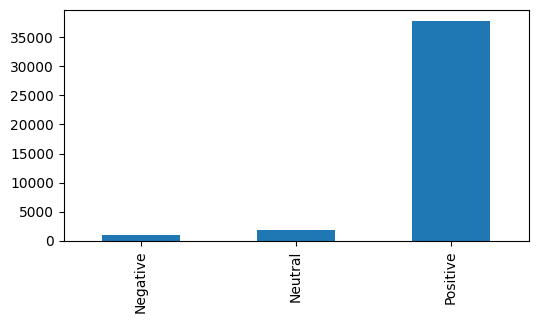

In [ ]:
rating = df_train['rating'].value_counts().sort_index().plot(kind='bar', figsize=(6,3))

In [ ]:
# Tambahkan kode di sini!
df_test2 = pd.DataFrame({'text':df_test['text'].values})
df_test2

,text
0,Warnanya tdk sesuai pesanan. Tdk ada chat/pemb...
1,Thanks gan barang bagus.smoga awet
2,barang sesuai deskripsi.. laptop dapat di-charge
3,Goood product.......... ............
4,Bagus pengiriman cepat.
5,Terima kasih pesanannya sdh sampai
6,"barangnya cacat, apa tidak diperiksa dulu?"
7,Barang sesuai pesanan
8,"Udah order ternyata stok ga tersedia, harusny..."
9,Pengiriman barang lambat


In [ ]:
df_test

,Unnamed: 0,text,category,product_name,product_id,clean,tokenized
0,0,Warnanya tdk sesuai pesanan. Tdk ada chat/pemb...,elektronik,USB HUB 3.0 7 port by DIGIGEAR HIGH SPEED 1.2 ...,170197447,warnanya sesuai pesanan chat pemberitahuan,"[warnanya, sesuai, pesanan, chat, pemberitahuan]"
1,1,Thanks gan barang bagus.smoga awet,handphone,Holder anti hujan &amp; copet untuk smartphone...,37564148,thanks gan barang bagus semoga awet,"[thanks, gan, barang, bagus, semoga, awet]"
2,2,barang sesuai deskripsi.. laptop dapat di-charge,elektronik,Adaptor Charger Laptop Toshiba Satellite C800 ...,254339251,barang sesuai deskripsi laptop charge,"[barang, sesuai, deskripsi, laptop, charge]"
3,3,Goood product.......... ............,handphone,Silikon Case Blackberry Bold 9000 Hitam Gratis...,4837401,goood product,"[goood, product]"
4,4,Bagus pengiriman cepat.,handphone,Audio Splitter Jack 3.5mm to dual female U Sha...,270447288,bagus pengiriman cepat,"[bagus, pengiriman, cepat]"
5,5,Terima kasih pesanannya sdh sampai,fashion,Celana jeans anak pendek,294837423,terima kasih pesanannya,"[terima, kasih, pesanannya]"
6,6,"barangnya cacat, apa tidak diperiksa dulu?",handphone,Tempelan / Perekat Gurita Hp Buat / untuk Goje...,56486193,barangnya cacat diperiksa,"[barangnya, cacat, diperiksa]"
7,7,Barang sesuai pesanan,elektronik,Baterai Acer Aspire One 722 D255 D257 D260 D27...,189413883,barang sesuai pesanan,"[barang, sesuai, pesanan]"
8,8,"Udah order ternyata stok ga tersedia, harusny...",fashion,Sepatu Bata Dairy Black - 6516353,194223236,order stok tersedia pasang etalase,"[order, stok, tersedia, pasang, etalase]"
9,9,Pengiriman barang lambat,elektronik,USB HUB 4 port USB 3.0 / USB HUB 3.0 &#40;4por...,182937734,pengiriman barang lambat,"[pengiriman, barang, lambat]"


# Analisis Teks

In [ ]:
def calculate_frequency_distribution(df):
    words = [word for words in df['tokenized'] for word in words]
    fqdist = FreqDist(words)
    return fqdist

In [ ]:
fqdist_train = calculate_frequency_distribution(df_train)
top_500 = fqdist_train.most_common(500)
top_500

[('barang', 15769),
 ('sesuai', 11564),
 ('cepat', 10145),
 ('bagus', 8154),
 ('terima', 6664),
 ('kasih', 5774),
 ('pengiriman', 4564),
 ('respon', 3921),
 ('gan', 3896),
 ('mantap', 3695),
 ('pesanan', 3158),
 ('produk', 3131),
 ('seller', 3011),
 ('diterima', 2891),
 ('deskripsi', 2803),
 ('rapi', 2474),
 ('packing', 2421),
 ('ok', 2399),
 ('thanks', 2343),
 ('barangnya', 2003),
 ('oke', 1932),
 ('kualitas', 1859),
 ('semoga', 1783),
 ('harga', 1766),
 ('fast', 1755),
 ('berfungsi', 1732),
 ('terimakasih', 1639),
 ('gambar', 1501),
 ('awet', 1439),
 ('recommended', 1358),
 ('good', 1357),
 ('sukses', 991),
 ('puas', 876),
 ('thx', 858),
 ('aman', 821),
 ('penjual', 798),
 ('pelayanan', 797),
 ('lumayan', 781),
 ('murah', 770),
 ('recomended', 751),
 ('pakai', 746),
 ('paket', 727),
 ('selamat', 727),
 ('mantab', 708),
 ('dicoba', 676),
 ('pas', 665),
 ('top', 661),
 ('warna', 653),
 ('dipakai', 646),
 ('bareng', 640),
 ('order', 613),
 ('jam', 611),
 ('sip', 607),
 ('beli', 606),
 (

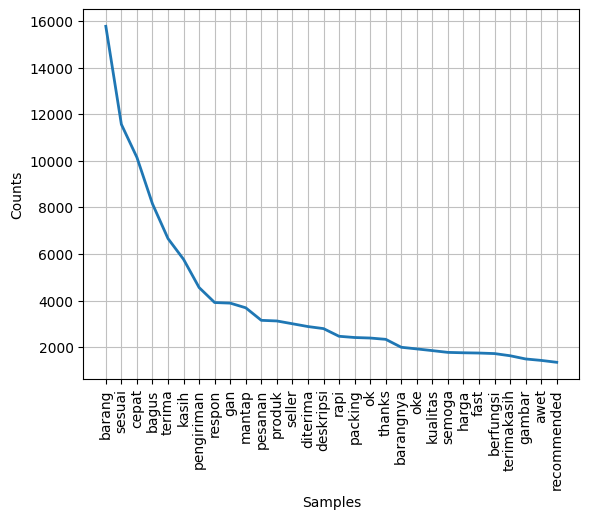

In [ ]:
fqdist_train = calculate_frequency_distribution(df_train)
fqdist_train.plot(30,cumulative=False)
plt.show()

In [ ]:
fqdist_test = calculate_frequency_distribution(df_test)
top_30 = fqdist_test.most_common(30)
top_30

[('barang', 4),
 ('sesuai', 3),
 ('pesanan', 2),
 ('bagus', 2),
 ('pengiriman', 2),
 ('warnanya', 1),
 ('chat', 1),
 ('pemberitahuan', 1),
 ('thanks', 1),
 ('gan', 1),
 ('semoga', 1),
 ('awet', 1),
 ('deskripsi', 1),
 ('laptop', 1),
 ('charge', 1),
 ('goood', 1),
 ('product', 1),
 ('cepat', 1),
 ('terima', 1),
 ('kasih', 1),
 ('pesanannya', 1),
 ('barangnya', 1),
 ('cacat', 1),
 ('diperiksa', 1),
 ('order', 1),
 ('stok', 1),
 ('tersedia', 1),
 ('pasang', 1),
 ('etalase', 1),
 ('lambat', 1)]

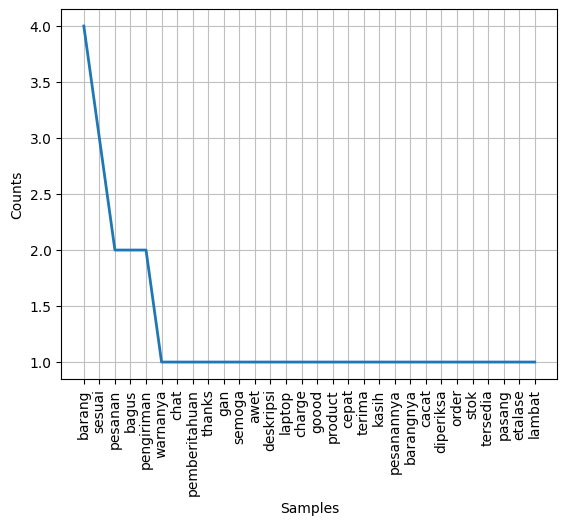

In [ ]:
fqdist_test = calculate_frequency_distribution(df_test)
fqdist_test.plot(30,cumulative=False)
plt.show()

# Analisis Data Train

In [ ]:
df_neg = df_train[df_train['rating'] == 'Positive']
fqdist_neg = calculate_frequency_distribution(df_neg)
top_100 = fqdist_neg.most_common(100)
top_100

[('barang', 14790),
 ('sesuai', 10928),
 ('cepat', 9863),
 ('bagus', 7854),
 ('terima', 6356),
 ('kasih', 5498),
 ('pengiriman', 4336),
 ('respon', 3768),
 ('gan', 3745),
 ('mantap', 3656),
 ('pesanan', 3037),
 ('produk', 2951),
 ('seller', 2944),
 ('diterima', 2759),
 ('deskripsi', 2708),
 ('rapi', 2378),
 ('packing', 2327),
 ('thanks', 2270),
 ('ok', 2268),
 ('barangnya', 1860),
 ('oke', 1849),
 ('fast', 1723),
 ('semoga', 1709),
 ('kualitas', 1696),
 ('berfungsi', 1644),
 ('terimakasih', 1586),
 ('harga', 1545),
 ('awet', 1397),
 ('gambar', 1391),
 ('recommended', 1344),
 ('good', 1333),
 ('sukses', 974),
 ('puas', 848),
 ('thx', 826),
 ('aman', 791),
 ('pelayanan', 748),
 ('murah', 735),
 ('recomended', 732),
 ('selamat', 704),
 ('penjual', 701),
 ('mantab', 700),
 ('paket', 676),
 ('top', 651),
 ('dicoba', 648),
 ('lumayan', 620),
 ('pakai', 597),
 ('bareng', 588),
 ('keren', 587),
 ('sip', 586),
 ('pas', 586),
 ('order', 568),
 ('bintang', 565),
 ('jam', 549),
 ('memuaskan', 542)

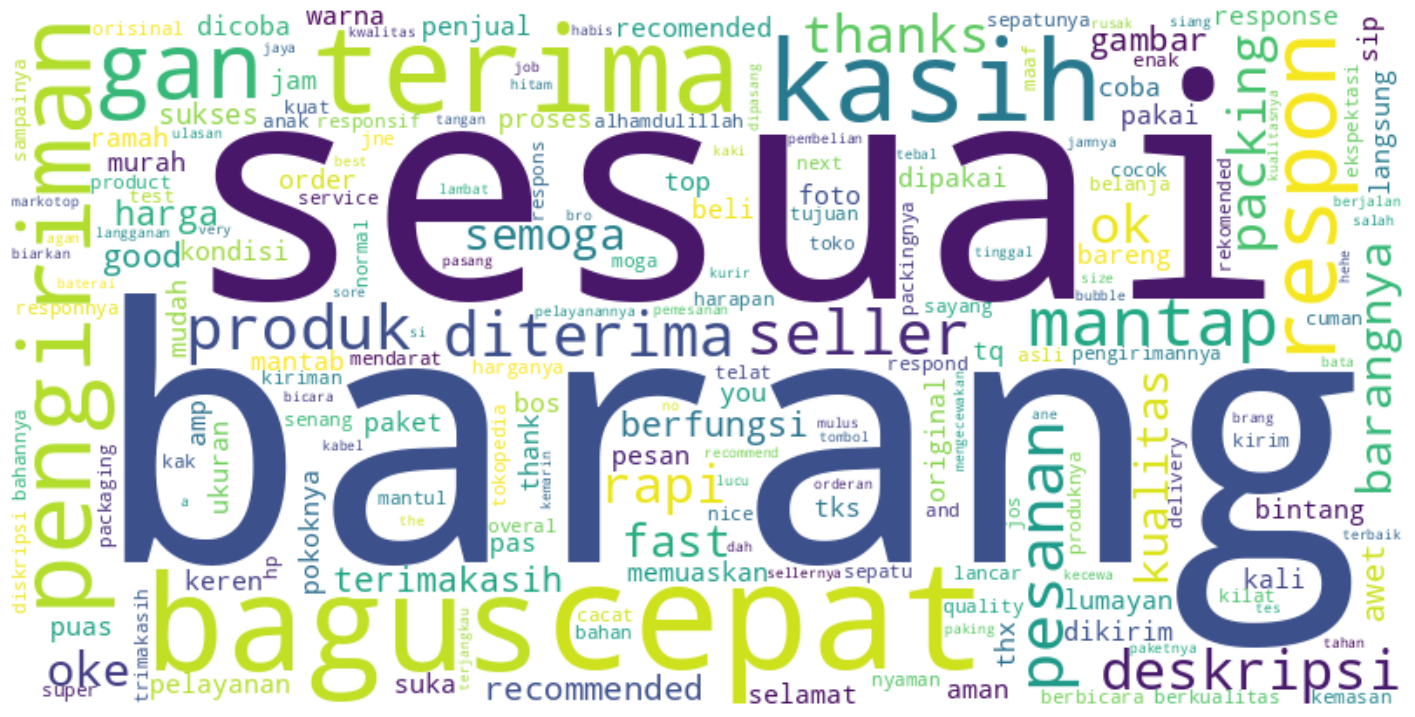

In [ ]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(fqdist_neg)
plt.figure(figsize=(18, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
df_pos = df_train[df_train['rating'] == 'Negative']
fqdist_pos = calculate_frequency_distribution(df_pos)
top_50 = fqdist_pos.most_common(50)
top_50

[('barang', 357),
 ('sesuai', 172),
 ('dikirim', 114),
 ('kecewa', 90),
 ('pakai', 86),
 ('produk', 68),
 ('warna', 68),
 ('beli', 64),
 ('bagus', 64),
 ('kirim', 63),
 ('pengiriman', 62),
 ('rusak', 62),
 ('pesan', 55),
 ('kualitas', 54),
 ('dipakai', 53),
 ('kasih', 53),
 ('penjual', 51),
 ('terima', 49),
 ('cepat', 47),
 ('gan', 45),
 ('barangnya', 45),
 ('hp', 45),
 ('berfungsi', 45),
 ('gambar', 40),
 ('kali', 39),
 ('respon', 37),
 ('harga', 37),
 ('deskripsi', 37),
 ('pesanan', 35),
 ('ukuran', 34),
 ('beda', 33),
 ('diterima', 32),
 ('salah', 30),
 ('tanggal', 29),
 ('order', 28),
 ('pembeli', 28),
 ('jelek', 27),
 ('pas', 26),
 ('jam', 26),
 ('bareng', 25),
 ('seller', 25),
 ('retur', 25),
 ('langsung', 25),
 ('mati', 25),
 ('habis', 24),
 ('nyala', 24),
 ('uang', 23),
 ('tolong', 23),
 ('packing', 23),
 ('size', 22)]

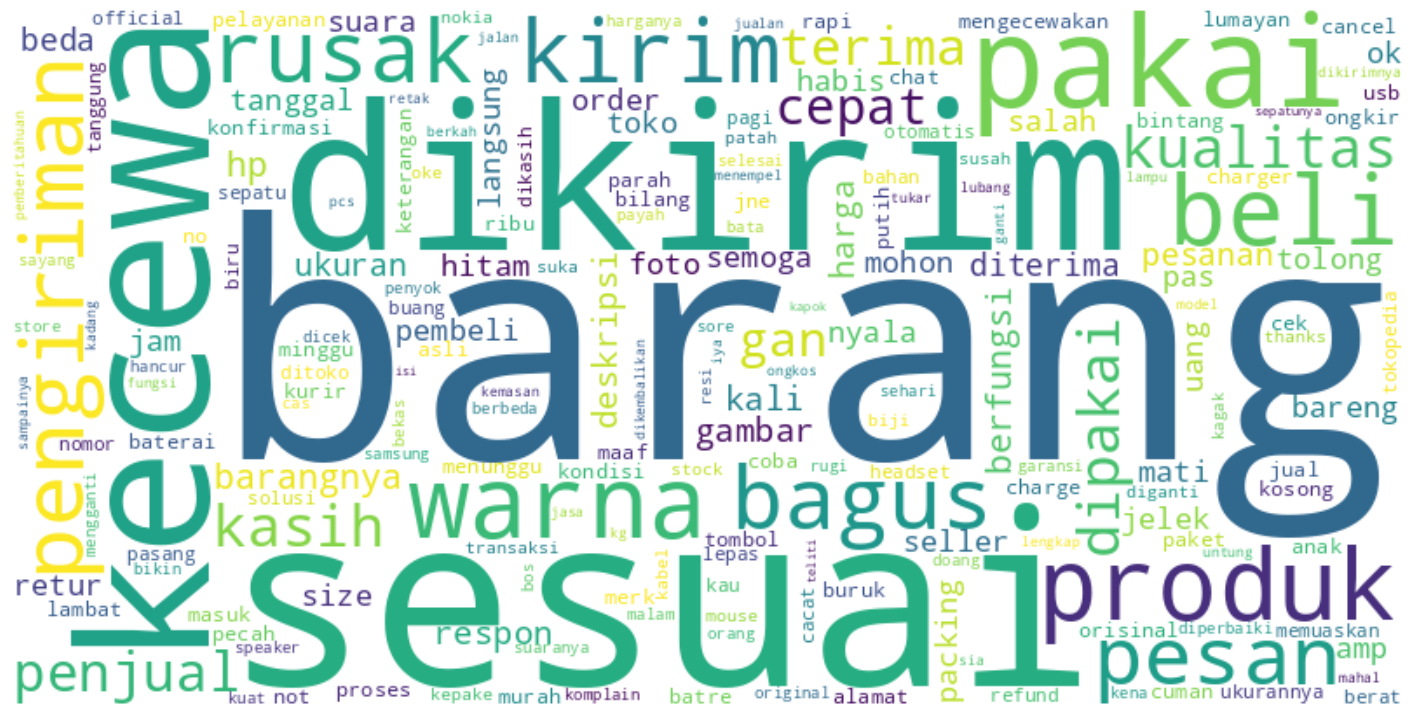

In [ ]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(fqdist_pos)
plt.figure(figsize=(18, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## MODELING

In [ ]:
vectorizer = TfidfVectorizer(max_features=2500)
model_g = GaussianNB()

In [ ]:
X = vectorizer.fit_transform(df_train['clean']).toarray()
y = df_train['rating']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
model_rf = RandomForestClassifier(max_depth=5, random_state=42, n_estimators=10)
model_rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, n_estimators=10, random_state=42)

In [56]:
y_preds = model_rf.predict(X_test)

print(confusion_matrix(y_test,y_preds))
print(classification_report(y_test,y_preds))
print('nilai akurasinya adalah ',accuracy_score(y_test, y_preds))

[[   0    0  178]
 [   0    0  330]
 [   0    0 7609]]
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00       178
     Neutral       0.00      0.00      0.00       330
    Positive       0.94      1.00      0.97      7609

    accuracy                           0.94      8117
   macro avg       0.31      0.33      0.32      8117
weighted avg       0.88      0.94      0.91      8117

nilai akurasinya adalah  0.9374153012196624


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
